In [ ]:
#130713

# Coursework 2

In this coursework, you will implement three different recommendation systems to recommend movies to users. Please read carefully the instructions provided in e-class.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Carregamento e Análise Inicial dos Dados

In [40]:
# Carregamento dos dados como numpy array - arquivo contém apenas dados sem headers
user_movie_matrix = np.loadtxt('U.csv', delimiter=',')
print("\nPrimeiras linhas e colunas:")
print(user_movie_matrix[:5, :5])


Primeiras linhas e colunas:
[[5. 3. 4. 3. 3.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [4. 3. 0. 0. 0.]]


In [41]:
# Verificação da esparsidade dos dados
total_entries = user_movie_matrix.shape[0] * user_movie_matrix.shape[1]
non_zero_entries = np.count_nonzero(user_movie_matrix)
sparsity = 1 - (non_zero_entries / total_entries)

print(f"\nEstatísticas da matriz:")
print(f"Número de usuários: {user_movie_matrix.shape[0]}")
print(f"Número de filmes: {user_movie_matrix.shape[1]}")
print(f"Entradas não-zero: {non_zero_entries}")
print(f"Esparsidade: {sparsity:.4f} ({sparsity*100:.2f}%)")


Estatísticas da matriz:
Número de usuários: 943
Número de filmes: 1682
Entradas não-zero: 100000
Esparsidade: 0.9370 (93.70%)


### Funções para Análise de Distribuições

In [42]:
def plot_ratings_histograms(matrix, title_suffix=""):
    """
    Plota histogramas de ratings por usuário e por filme lado a lado
    """
    # Contagem de ratings por usuário
    ratings_per_user = np.count_nonzero(matrix, axis=1)

    # Contagem de ratings por filme
    ratings_per_movie = np.count_nonzero(matrix, axis=0)

    # Criando subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Histograma de ratings por usuário
    ax1.hist(ratings_per_user, bins=60, color='green', label='Usuários')
    ax1.set_xlabel('Contagem de Ratings dados')
    ax1.set_ylabel('Número de Usuários')
    ax1.set_title(f'Distribuição de Ratings por Usuário{title_suffix}')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Histograma de ratings por filme
    ax2.hist(ratings_per_movie, bins=60, color='orange', label='Filmes')
    ax2.set_xlabel('Contagem de Ratings recebidos')
    ax2.set_ylabel('Número de Filmes')
    ax2.set_title(f'Distribuição de Ratings por Filme{title_suffix}')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

Análise do Dataset Original:


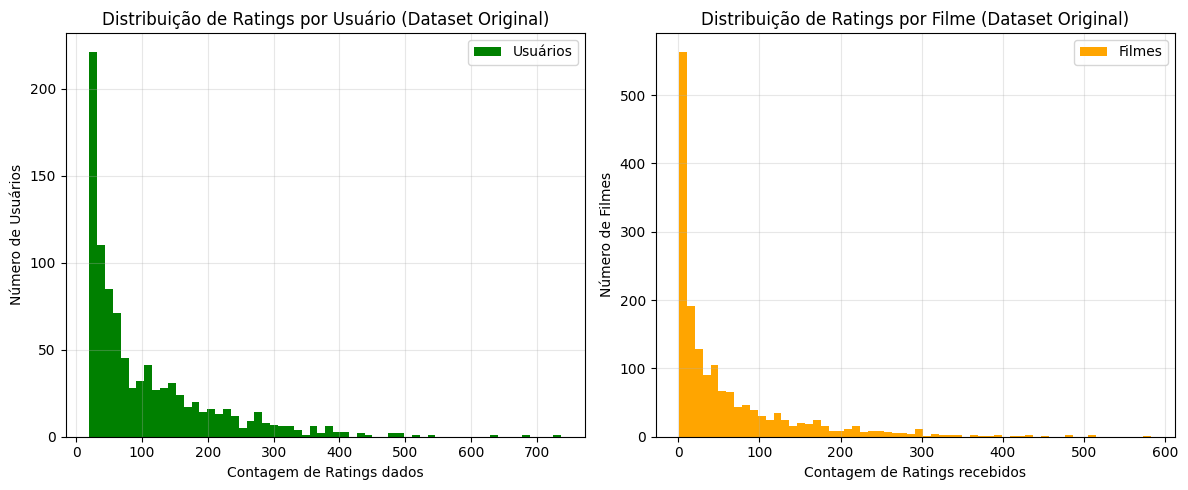

In [43]:
# Plotando histogramas para o dataset original
print("Análise do Dataset Original:")
plot_ratings_histograms(user_movie_matrix, " (Dataset Original)")

### Divisão dos Dados em Treino, Validação e Teste

In [44]:
# Move para o conjunto certo, retirando do treino, verificando se a coluna não ficará vazia
def move_ratings(user_idx, train_matrix, to_matrix, to_move_idx, remaining_movies, min_rated_per_movie = 1):
    """
    Move ratings de um usuário da matriz de treino para outra matriz (validação ou teste),
    garantindo que nenhuma coluna fique sem ratings.
    """
    for idx in to_move_idx:
        # Verifica se há mais de 1 rating para este filme
        if np.count_nonzero(train_matrix[:, idx]) > min_rated_per_movie:
            to_matrix[user_idx, idx] = train_matrix[user_idx, idx]
            train_matrix[user_idx, idx] = 0
        else:
            if len(remaining_movies) > 0:
                print(f"Aviso: Filme {idx} não pode ser movido (ficaria sem ratings). Escolhendo substituto...")
                new_movie_idx = np.random.choice(remaining_movies)
                remaining_movies.remove(new_movie_idx)
                train_matrix, to_matrix, remaining_movies = move_ratings(user_idx, train_matrix, to_matrix, [new_movie_idx], remaining_movies, min_rated_per_movie)
            else:
                print(f"Aviso: Não há filmes restantes para substituir o filme {idx}")

    return train_matrix, to_matrix, remaining_movies

def train_test_split(matrix, n_val=5, n_test=5):
    """
    Divide os dados em conjuntos de treino, validação e teste.
    Para cada usuário, remove aleatoriamente 10 ratings: 5 para validação e 5 para teste.
    """
    train_matrix = matrix.copy()
    val_matrix = np.zeros_like(train_matrix)
    test_matrix = np.zeros_like(train_matrix)

    # Para cada usuário
    for user_idx in range(matrix.shape[0]):
        rated_movies = np.where(matrix[user_idx] > 0)[0]
        selected_movies = np.random.choice(rated_movies, size=n_val+n_test, replace=False)
        remaining_movies = [m for m in rated_movies if m not in selected_movies]

        # Dividir em validação (primeiros 5) e teste (últimos 5)
        val_movies = selected_movies[:n_val]
        test_movies = selected_movies[n_val:]

        train_matrix, val_matrix, remaining_movies = move_ratings(user_idx, train_matrix, val_matrix, val_movies, remaining_movies)
        train_matrix, test_matrix, remaining_movies = move_ratings(user_idx, train_matrix, test_matrix, test_movies, remaining_movies)

    # Verificar estatísticas finais
    ratings_per_movie = np.count_nonzero(train_matrix, axis=0)
    print(f"Filme com menos ratings tem {np.min(ratings_per_movie)} ratings")

    return train_matrix, val_matrix, test_matrix

In [45]:
# Configurar seed para reprodutibilidade
np.random.seed(42)

# Dividir os dados
train_matrix, val_matrix, test_matrix = train_test_split(user_movie_matrix)

Aviso: Filme 1637 não pode ser movido (ficaria sem ratings). Escolhendo substituto...
Aviso: Filme 1653 não pode ser movido (ficaria sem ratings). Escolhendo substituto...
Aviso: Filme 1670 não pode ser movido (ficaria sem ratings). Escolhendo substituto...
Filme com menos ratings tem 1 ratings


## 2. Implementação do Sistema de Recomendação usando NMF

In [46]:
def nmf(matrix, k, max_iter=1000, tol=0.01, alpha=0.0001, beta=0.0001, epsilon=1e-9):
    """
    Implementa o algoritmo Non-negative Matrix Factorization (NMF) com regularização.

    Parâmetros:
    - matrix: matriz de treino Y (usuários x filmes)
    - k: número de fatores latentes
    - max_iter: número máximo de iterações
    - tol: tolerância para convergência
    - alpha: parâmetro de regularização para W
    - beta: parâmetro de regularização para H
    - epsilon: pequeno valor para evitar divisão por zero

    Retorna:
    - W: matriz de fatores latentes dos usuários (usuários x k)
    - H: matriz de fatores latentes dos filmes (k x filmes)
    - losses: vetor com os valores de perda em cada iteração
    """
    n_users, n_movies = matrix.shape
    Y = matrix.copy()

    # Inicializa W e H com valores pequenos não-negativos
    #np.random.seed(42)
    W = np.random.rand(n_users, k) * 0.1
    H = np.random.rand(k, n_movies) * 0.1

    # Normaliza as colunas de W para somar 1
    W = W / np.sum(W, axis=0, keepdims=True)
    H = H / np.sum(H, axis=1, keepdims=True)

    # Máscara para elementos não-zero na matriz original
    mask = (Y > 0).astype(float)

    # Vetor para armazenar os valores de perda
    losses = []

    # Iterações do algoritmo
    for iter in range(max_iter):
        W_old = W.copy()
        H_old = H.copy()

        # Calcula a perda atual (RMSE nos elementos observados)
        prediction = W @ H
        error = mask * (Y - prediction)
        loss = np.sqrt(np.sum(error**2) / np.sum(mask)) #RMSE com máscara
        losses.append(loss)

        # Atualização de H usando a fórmula regularizada
        numerator_H = (W.T @ Y) - beta * H
        denominator_H = (W.T @ W @ H) + epsilon
        H = H * numerator_H / denominator_H

        # Atualização de W usando a fórmula regularizada
        numerator_W = (Y @ H.T) - alpha * W
        denominator_W = (W @ H @ H.T) + epsilon
        W = W * numerator_W / denominator_W

        # Normaliza colunas de W para somar 1
        W = W / np.sum(W, axis=0, keepdims=True)

        if H.sum() > 50*k*n_movies:
            print(f"H é muito grande, normalizando. Considere diminuir o valor de beta.")
            epsilon = 1e-5
            H = H / np.sum(H, axis=1, keepdims=True)

        # Verifica convergência
        W_change = np.max(np.abs(W - W_old)) / (np.max(W_old))
        H_change = np.max(np.abs(H - H_old)) / (np.max(H_old))

        if W_change < tol and H_change < tol:
            print(f"Convergência alcançada após {iter+1} iterações")
            break

        # Print para debugar
        #print(f"Soma total de H: {H.sum()}")

    if iter == max_iter - 1:
        print(f"Número máximo de iterações ({max_iter}) alcançado sem convergência")

    return W, H, losses

In [47]:
# Executar o algoritmo NMF no conjunto de treinamento
k = 10
W, H, losses = nmf(train_matrix, k, alpha=0.001, beta=0.0001)

Convergência alcançada após 57 iterações


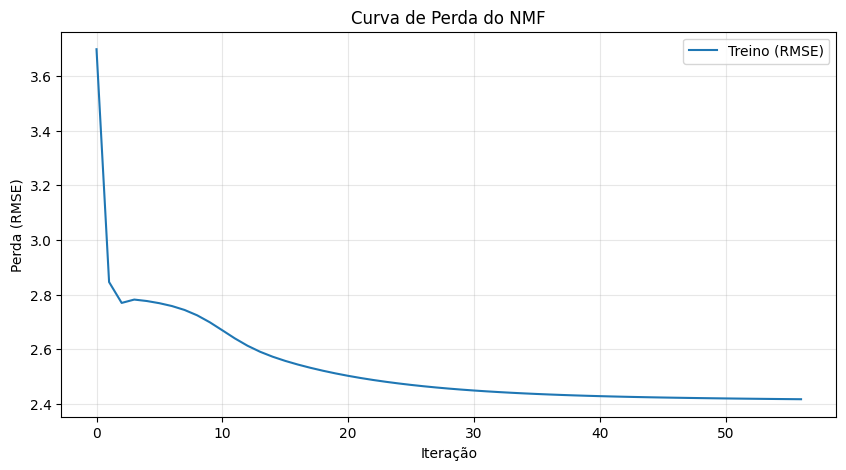

In [48]:
# Visualizar a curva de perda
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Treino (RMSE)')
plt.xlabel('Iteração')
plt.ylabel('Perda (RMSE)')
plt.title('Curva de Perda do NMF')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [49]:
# Gerar previsões usando o modelo NMF
predictions = W @ H

# Comparar previsões com valores reais no conjunto de treinamento
print("\nComparação de previsões no conjunto de treinamento:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(train_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = train_matrix[user, movie]
    pred = predictions[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")

# Selecionar 10 pontos aleatórios com avaliações = 0
zero_indices = np.where(train_matrix == 0)
random_indices = np.random.choice(len(zero_indices[0]), 10, replace=False)
print("\nPontos com avaliações = 0:")
for i in random_indices:
    user = zero_indices[0][i]
    movie = zero_indices[1][i]
    pred = predictions[user, movie]
    print(f"Usuário {user}, Filme {movie}: Previsto = {pred:.2f}")


Comparação de previsões no conjunto de treinamento:

Pontos com avaliações > 0:
Usuário 278, Filme 1265: Real = 1.00, Previsto = 0.06, Erro = 0.94
Usuário 213, Filme 171: Real = 3.00, Previsto = 2.81, Erro = 0.19
Usuário 222, Filme 317: Real = 4.00, Previsto = 1.48, Erro = 2.52
Usuário 140, Filme 290: Real = 5.00, Previsto = 2.41, Erro = 2.59
Usuário 721, Filme 822: Real = 3.00, Previsto = 0.39, Erro = 2.61
Usuário 123, Filme 194: Real = 4.00, Previsto = 0.58, Erro = 3.42
Usuário 144, Filme 202: Real = 5.00, Previsto = 2.08, Erro = 2.92
Usuário 842, Filme 614: Real = 3.00, Previsto = 0.90, Erro = 2.10
Usuário 462, Filme 6: Real = 4.00, Previsto = 2.41, Erro = 1.59
Usuário 63, Filme 878: Real = 3.00, Previsto = 0.62, Erro = 2.38

Pontos com avaliações = 0:
Usuário 884, Filme 907: Previsto = 0.00
Usuário 681, Filme 463: Previsto = 0.32
Usuário 704, Filme 1349: Previsto = 0.02
Usuário 908, Filme 461: Previsto = 0.52
Usuário 724, Filme 273: Previsto = 0.44
Usuário 54, Filme 766: Previsto 

In [50]:
# Comparar previsões com valores reais no conjunto de validação
print("\nComparação de previsões no conjunto de validação:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(val_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = val_matrix[user, movie]
    pred = predictions[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")



Comparação de previsões no conjunto de validação:

Pontos com avaliações > 0:
Usuário 735, Filme 531: Real = 4.00, Previsto = 0.03, Erro = 3.97
Usuário 408, Filme 473: Real = 5.00, Previsto = 3.73, Erro = 1.27
Usuário 127, Filme 215: Real = 5.00, Previsto = 3.90, Erro = 1.10
Usuário 559, Filme 301: Real = 5.00, Previsto = 1.02, Erro = 3.98
Usuário 629, Filme 116: Real = 5.00, Previsto = 3.39, Erro = 1.61
Usuário 761, Filme 236: Real = 3.00, Previsto = 0.25, Erro = 2.75
Usuário 707, Filme 327: Real = 3.00, Previsto = 2.33, Erro = 0.67
Usuário 571, Filme 1170: Real = 3.00, Previsto = 0.03, Erro = 2.97
Usuário 462, Filme 748: Real = 3.00, Previsto = 0.04, Erro = 2.96
Usuário 73, Filme 301: Real = 4.00, Previsto = 1.69, Erro = 2.31


In [51]:
# Comparar previsões com valores reais no conjunto de teste
print("\nComparação de previsões no conjunto de teste:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(test_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = test_matrix[user, movie]
    pred = predictions[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")


Comparação de previsões no conjunto de teste:

Pontos com avaliações > 0:
Usuário 922, Filme 0: Real = 3.00, Previsto = 2.40, Erro = 0.60
Usuário 908, Filme 338: Real = 4.00, Previsto = 0.12, Erro = 3.88
Usuário 405, Filme 431: Real = 5.00, Previsto = 2.48, Erro = 2.52
Usuário 608, Filme 242: Real = 1.00, Previsto = 0.11, Erro = 0.89
Usuário 692, Filme 630: Real = 3.00, Previsto = 0.74, Erro = 2.26
Usuário 740, Filme 723: Real = 4.00, Previsto = 0.56, Erro = 3.44
Usuário 1, Filme 308: Real = 1.00, Previsto = 0.13, Erro = 0.87
Usuário 291, Filme 627: Real = 3.00, Previsto = 1.03, Erro = 1.97
Usuário 236, Filme 497: Real = 4.00, Previsto = 0.98, Erro = 3.02
Usuário 169, Filme 983: Real = 5.00, Previsto = 0.14, Erro = 4.86


In [52]:
# Calcular RMSE no conjunto de validação
val_mask = (val_matrix > 0).astype(int)
val_error = val_mask * (val_matrix - predictions)
val_rmse = np.sqrt(np.sum(val_error**2) / np.sum(val_mask))
print(f"\nRMSE no conjunto de validação: {val_rmse:.4f}")


RMSE no conjunto de validação: 2.9187


## 3. Implementação do Sistema de Recomendação usando SLIM

### v1 - Gradient Descent

In [96]:
def slim(matrix, learning_rate=0.001, l2_reg=0.001, l1_reg=0.001, max_iter=1000, tol=0.01):
    """
    Implementa o algoritmo SLIM com gradiente descendente e projeção.

    Parâmetros:
    - R: matriz de treino (usuários x itens)
    - learning_rate: taxa de aprendizado
    - l2_reg: regularização L2
    - l1_reg: regularização L1
    - max_iter: número máximo de iterações
    - tol: tolerância para convergência

    Retorna:
    - W: matriz de similaridade entre itens
    - losses: valores de perda em cada iteração
    """
    R = matrix.copy()
    n_items = R.shape[1]

    mask = (R > 0).astype(int)

    # Inicialização com valores pequenos
    W = np.random.rand(n_items, n_items) * 0.01
    np.fill_diagonal(W, 0)  # Garantir que Wii = 0

    losses = []

    # Iterações do algoritmo
    for iter in range(max_iter):
        W_old = W.copy()

        error = mask * (R - R @ W) #Coloquei mascara, mas não tenho certeza se posso

        # Gradiente
        gradient = -R.T @ error + l2_reg * W + l1_reg * np.sign(W)
        W -= learning_rate * gradient

        # Restrição
        W[W < 0] = 0
        np.fill_diagonal(W, 0)

        # Calcula RMSE
        error = mask * (R - R @ W)
        loss = np.sqrt(np.sum(error**2) / np.sum(mask))
        if iter % 10 == 0:
            #print(f"Iteração {iter} com loss: {loss}")
            pass
        losses.append(loss)

        # Verificação de convergência
        change = np.max(np.abs(W - W_old)) / (np.max(W_old))
        if change < tol:
            print(f"Convergência alcançada após {iter+1} iterações")
            break

    if iter == max_iter - 1:
        print(f"Número máximo de iterações ({max_iter}) alcançado sem convergência")

    return W, losses

In [76]:
# Executar o algoritmo SLIM no conjunto de treinamento
learning_rate = 0.000001  # Reduzido para evitar instabilidade
l2_reg = 0.001
l1_reg = 0.01
max_iter = 1000

W, losses_slim = slim(train_matrix, learning_rate, l2_reg, l1_reg, max_iter)

Iteração 0 com loss: 2.47052545991972
Iteração 10 com loss: 2.220106798055514
Iteração 20 com loss: 2.0967277000882456
Iteração 30 com loss: 2.0087263987126858
Iteração 40 com loss: 1.9388488987574726
Iteração 50 com loss: 1.8807843031842935
Iteração 60 com loss: 1.831307855162007
Convergência alcançada após 66 iterações


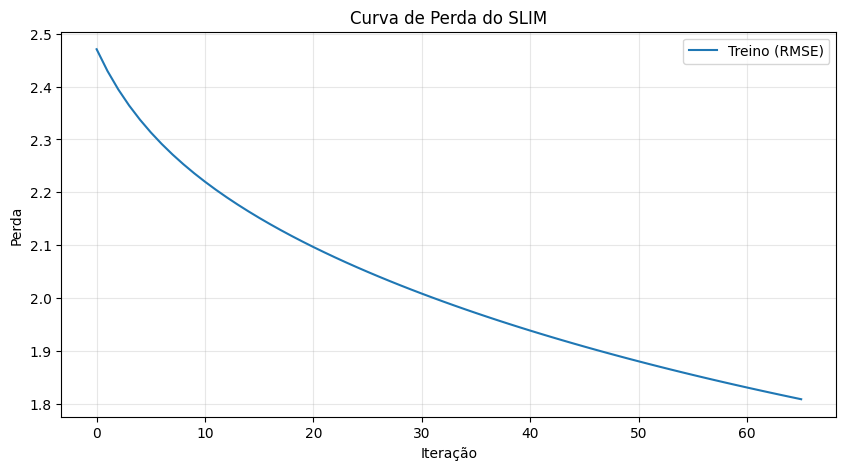

In [77]:
# Visualizar a curva de perda
plt.figure(figsize=(10, 5))
plt.plot(losses_slim, label='Treino (RMSE)')
plt.xlabel('Iteração')
plt.ylabel('Perda')
plt.title('Curva de Perda do SLIM')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [79]:
# Gerar previsões usando o modelo SLIM
predictions_slim = train_matrix @ W

# Comparar previsões com valores reais no conjunto de treinamento
print("\nComparação de previsões no conjunto de treinamento:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(train_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = train_matrix[user, movie]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")

# Selecionar 10 pontos aleatórios com avaliações = 0
zero_indices = np.where(train_matrix == 0)
random_indices = np.random.choice(len(zero_indices[0]), 10, replace=False)
print("\nPontos com avaliações = 0:")
for i in random_indices:
    user = zero_indices[0][i]
    movie = zero_indices[1][i]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Previsto = {pred:.2f}")


Comparação de previsões no conjunto de treinamento:

Pontos com avaliações > 0:
Usuário 746, Filme 300: Real = 1.00, Previsto = 3.65, Erro = 2.65
Usuário 789, Filme 565: Real = 3.00, Previsto = 2.90, Erro = 0.10
Usuário 17, Filme 21: Real = 5.00, Previsto = 4.25, Erro = 0.75
Usuário 710, Filme 98: Real = 3.00, Previsto = 3.46, Erro = 0.46
Usuário 183, Filme 496: Real = 4.00, Previsto = 3.57, Erro = 0.43
Usuário 293, Filme 146: Real = 4.00, Previsto = 3.34, Erro = 0.66
Usuário 339, Filme 427: Real = 1.00, Previsto = 0.66, Erro = 0.34
Usuário 539, Filme 627: Real = 3.00, Previsto = 1.71, Erro = 1.29
Usuário 795, Filme 55: Real = 5.00, Previsto = 6.01, Erro = 1.01
Usuário 891, Filme 614: Real = 5.00, Previsto = 3.49, Erro = 1.51

Pontos com avaliações = 0:
Usuário 884, Filme 1619: Previsto = 1.21
Usuário 535, Filme 600: Previsto = 1.98
Usuário 396, Filme 1536: Previsto = 1.66
Usuário 457, Filme 1486: Previsto = 2.44
Usuário 363, Filme 136: Previsto = 0.22
Usuário 885, Filme 314: Previsto

In [80]:
# Comparar previsões com valores reais no conjunto de validação
print("\nComparação de previsões SLIM no conjunto de validação:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(val_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = val_matrix[user, movie]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")



Comparação de previsões SLIM no conjunto de validação:

Pontos com avaliações > 0:
Usuário 726, Filme 981: Real = 4.00, Previsto = 3.33, Erro = 0.67
Usuário 612, Filme 606: Real = 4.00, Previsto = 0.32, Erro = 3.68
Usuário 260, Filme 242: Real = 5.00, Previsto = 0.43, Erro = 4.57
Usuário 134, Filme 257: Real = 4.00, Previsto = 0.72, Erro = 3.28
Usuário 239, Filme 300: Real = 5.00, Previsto = 0.91, Erro = 4.09
Usuário 294, Filme 560: Real = 5.00, Previsto = 2.37, Erro = 2.63
Usuário 198, Filme 322: Real = 3.00, Previsto = 0.66, Erro = 2.34
Usuário 697, Filme 210: Real = 2.00, Previsto = 2.05, Erro = 0.05
Usuário 893, Filme 1114: Real = 4.00, Previsto = 4.27, Erro = 0.27
Usuário 553, Filme 283: Real = 3.00, Previsto = 2.01, Erro = 0.99


In [81]:
# Comparar previsões com valores reais no conjunto de teste
print("\nComparação de previsões SLIM no conjunto de teste:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(test_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = test_matrix[user, movie]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")



Comparação de previsões SLIM no conjunto de teste:

Pontos com avaliações > 0:
Usuário 575, Filme 236: Real = 4.00, Previsto = 1.34, Erro = 2.66
Usuário 467, Filme 158: Real = 3.00, Previsto = 1.75, Erro = 1.25
Usuário 355, Filme 311: Real = 3.00, Previsto = 0.33, Erro = 2.67
Usuário 422, Filme 688: Real = 4.00, Previsto = 1.06, Erro = 2.94
Usuário 18, Filme 434: Real = 5.00, Previsto = 0.23, Erro = 4.77
Usuário 583, Filme 228: Real = 3.00, Previsto = 0.48, Erro = 2.52
Usuário 563, Filme 301: Real = 3.00, Previsto = 1.00, Erro = 2.00
Usuário 243, Filme 630: Real = 4.00, Previsto = 2.94, Erro = 1.06
Usuário 111, Filme 288: Real = 5.00, Previsto = 1.35, Erro = 3.65
Usuário 221, Filme 207: Real = 3.00, Previsto = 5.47, Erro = 2.47


In [82]:
# Calcular RMSE no conjunto de validação
val_mask = (val_matrix > 0).astype(int)
val_error_slim = val_mask * (val_matrix - predictions_slim)
val_rmse_slim = np.sqrt(np.sum(val_error_slim**2) / np.sum(val_mask))
print(f"\nRMSE do SLIM no conjunto de validação: {val_rmse_slim:.4f}")


RMSE do SLIM no conjunto de validação: 2.5023


### v2 - Descida de coordenada

A versão com descida de gradiente (chamada de v1, acima) não estava funcionando. Depois, descobri que era por conta do learning rate. De qualquer forma, implementei uma versão inspirada nesse github:

https://github.com/KarypisLab/SLIM

Ela usa descida de coordenada, fazendo uma atualização por vez. Ela é **MUITO** mais lenta, realmente muito, mas é bem estável.

In [92]:
def slim_desc_cord(matrix, l2_reg=0.001, l1_reg=0.001, max_iter=10, tol=0.01):
    """
    Implementa o algoritmo SLIM com descida de coordenada e projeção.

    Parâmetros:
    - R: matriz de treino (usuários x itens)
    - learning_rate: taxa de aprendizado (não usada diretamente na Descida Coordenada simples, mas mantida para assinatura da função)
    - l2_reg: regularização L2
    - l1_reg: regularização L1
    - max_iter: número máximo de iterações
    - tol: tolerância para convergência

    Retorna:
    - W: matriz de similaridade entre itens
    - losses: valores de perda em cada iteração
    """
    R = matrix.copy()
    n_users, n_items = R.shape

    mask = (R > 0).astype(int)

    # Inicialização com valores pequenos não-negativos
    W = np.random.rand(n_items, n_items) * 0.01
    np.fill_diagonal(W, 0)  # Garantir que Wii = 0

    # Pré-computar as normas
    R_col_norms_sq = np.sum(R**2, axis=0)

    # Inicializa a matriz que será atualizada incrementalmente.
    R_hat = R @ W

    losses = []

    # Iterações do algoritmo
    for iter_main in range(max_iter):
        W_old = W.copy()

        # Loop sobre cada item 'j' que será o item alvo (coluna 'j' em W)
        for j in range(n_items):
            target_column_Rj = R[:, j]

            # Loop sobre cada item 'k' que contribuirá para a predição do item 'j' (coluna 'k' em W_j)
            for k in range(n_items):
                if j == k:
                    continue

                old_W_jk = W[j, k]

                if R_col_norms_sq[k] == 0:
                    continue

                # Calcula o denominador da atualização coordenada com regularização L2
                denominator_val = R_col_norms_sq[k] + l2_reg

                # Calcula numerador: produto interno entre colunas R_k e R_j menos predição atual
                term_aTy = np.dot(R[:, k], target_column_Rj)
                y_hat_without_old_W_jk = R_hat[:, j] - R[:, k] * old_W_jk
                term_ip = np.dot(R[:, k], y_hat_without_old_W_jk)
                numerator_val = term_aTy - term_ip

                # Aplica soft thresholding para regularização L1
                if numerator_val > l1_reg:
                    new_W_jk = (numerator_val - l1_reg) / denominator_val
                else:
                    new_W_jk = 0.0

                # Atualiza W e a predição incrementalmente se houve mudança
                if new_W_jk != old_W_jk:
                    W[j, k] = new_W_jk
                    R_hat[:, j] += R[:, k] * (new_W_jk - old_W_jk)

        # Calcula o RMSE
        error = mask * (R - R_hat)
        loss = np.sqrt(np.sum(error**2) / np.sum(mask))
        losses.append(loss)

        # Verificação de convergência
        change = np.max(np.abs(W - W_old)) / (np.max(W_old))
        if change < tol:
            print(f"Convergência alcançada após {iter+1} iterações")
            break

    if iter_main == max_iter - 1:
        print(f"Número máximo de iterações ({max_iter}) alcançado sem convergência")

    return W, losses

In [60]:
# Executar o algoritmo SLIM no conjunto de treinamento
l2_reg = 0.001
l1_reg = 0.01
max_iter = 10

W, losses_slim = slim_desc_cord(train_matrix, l2_reg, l1_reg, max_iter)

Número máximo de iterações (10) alcançado sem convergência


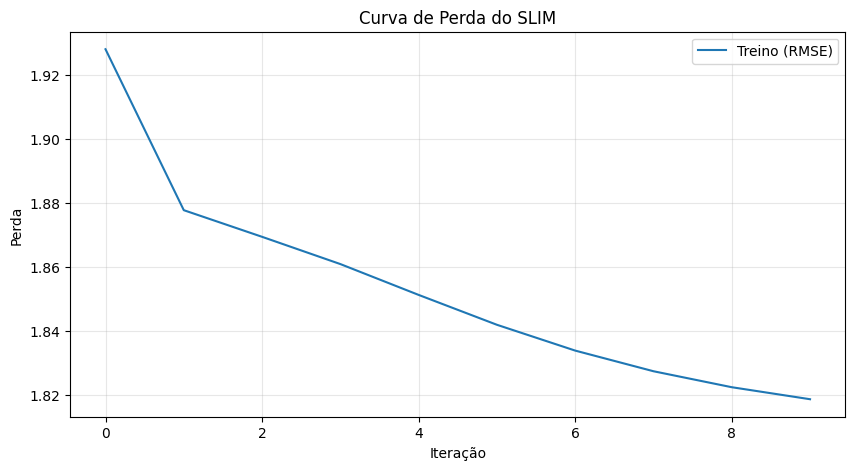

In [61]:
# Visualizar a curva de perda
plt.figure(figsize=(10, 5))
plt.plot(losses_slim, label='Treino (RMSE)')
plt.xlabel('Iteração')
plt.ylabel('Perda')
plt.title('Curva de Perda do SLIM')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [62]:
# Gerar previsões usando o modelo SLIM
predictions_slim = train_matrix @ W

# Comparar previsões com valores reais no conjunto de treinamento
print("\nComparação de previsões no conjunto de treinamento:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(train_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = train_matrix[user, movie]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")

# Selecionar 10 pontos aleatórios com avaliações = 0
zero_indices = np.where(train_matrix == 0)
random_indices = np.random.choice(len(zero_indices[0]), 10, replace=False)
print("\nPontos com avaliações = 0:")
for i in random_indices:
    user = zero_indices[0][i]
    movie = zero_indices[1][i]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Previsto = {pred:.2f}")


Comparação de previsões no conjunto de treinamento:

Pontos com avaliações > 0:
Usuário 678, Filme 356: Real = 5.00, Previsto = 1.10, Erro = 3.90
Usuário 150, Filme 524: Real = 4.00, Previsto = 2.15, Erro = 1.85
Usuário 726, Filme 401: Real = 3.00, Previsto = 1.17, Erro = 1.83
Usuário 110, Filme 306: Real = 2.00, Previsto = 0.44, Erro = 1.56
Usuário 532, Filme 401: Real = 4.00, Previsto = 0.85, Erro = 3.15
Usuário 166, Filme 287: Real = 3.00, Previsto = 0.00, Erro = 3.00
Usuário 501, Filme 538: Real = 3.00, Previsto = 2.74, Erro = 0.26
Usuário 300, Filme 41: Real = 4.00, Previsto = 0.52, Erro = 3.48
Usuário 540, Filme 698: Real = 4.00, Previsto = 1.47, Erro = 2.53
Usuário 681, Filme 1177: Real = 1.00, Previsto = 1.25, Erro = 0.25

Pontos com avaliações = 0:
Usuário 481, Filme 1546: Previsto = 0.00
Usuário 686, Filme 597: Previsto = 1.18
Usuário 194, Filme 616: Previsto = 1.09
Usuário 284, Filme 358: Previsto = 0.00
Usuário 885, Filme 520: Previsto = 1.08
Usuário 898, Filme 588: Previs

In [63]:
# Comparar previsões com valores reais no conjunto de validação
print("\nComparação de previsões SLIM no conjunto de validação:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(val_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = val_matrix[user, movie]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")



Comparação de previsões SLIM no conjunto de validação:

Pontos com avaliações > 0:
Usuário 429, Filme 272: Real = 4.00, Previsto = 0.41, Erro = 3.59
Usuário 927, Filme 7: Real = 5.00, Previsto = 0.12, Erro = 4.88
Usuário 410, Filme 185: Real = 5.00, Previsto = 0.89, Erro = 4.11
Usuário 849, Filme 78: Real = 5.00, Previsto = 0.49, Erro = 4.51
Usuário 680, Filme 327: Real = 3.00, Previsto = 0.03, Erro = 2.97
Usuário 181, Filme 110: Real = 4.00, Previsto = 0.79, Erro = 3.21
Usuário 706, Filme 479: Real = 3.00, Previsto = 1.18, Erro = 1.82
Usuário 523, Filme 1064: Real = 1.00, Previsto = 4.59, Erro = 3.59
Usuário 6, Filme 479: Real = 4.00, Previsto = 1.47, Erro = 2.53
Usuário 311, Filme 442: Real = 4.00, Previsto = 0.46, Erro = 3.54


In [64]:
# Comparar previsões com valores reais no conjunto de teste
print("\nComparação de previsões SLIM no conjunto de teste:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(test_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = test_matrix[user, movie]
    pred = predictions_slim[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")



Comparação de previsões SLIM no conjunto de teste:

Pontos com avaliações > 0:
Usuário 600, Filme 68: Real = 3.00, Previsto = 3.27, Erro = 0.27
Usuário 64, Filme 1040: Real = 3.00, Previsto = 1.43, Erro = 1.57
Usuário 820, Filme 404: Real = 4.00, Previsto = 0.78, Erro = 3.22
Usuário 798, Filme 318: Real = 4.00, Previsto = 0.77, Erro = 3.23
Usuário 534, Filme 13: Real = 3.00, Previsto = 2.19, Erro = 0.81
Usuário 82, Filme 1100: Real = 2.00, Previsto = 1.16, Erro = 0.84
Usuário 628, Filme 879: Real = 4.00, Previsto = 0.23, Erro = 3.77
Usuário 467, Filme 245: Real = 5.00, Previsto = 0.31, Erro = 4.69
Usuário 790, Filme 268: Real = 4.00, Previsto = 0.65, Erro = 3.35
Usuário 182, Filme 257: Real = 3.00, Previsto = 0.45, Erro = 2.55


In [65]:
# Calcular RMSE no conjunto de validação
val_mask = (val_matrix > 0).astype(int)
val_error_slim = val_mask * (val_matrix - predictions_slim)
val_rmse_slim = np.sqrt(np.sum(val_error_slim**2) / np.sum(val_mask))
print(f"\nRMSE do SLIM no conjunto de validação: {val_rmse_slim:.4f}")



RMSE do SLIM no conjunto de validação: 3.8835


## 4. Implementação do Sistema de Recomendação usando SVD

In [66]:
def svd(matrix, k, max_iter=1000, tol=0.01, regularization=0.0):
    """
    Implementa o algoritmo de recomendação baseado em SVD para matrizes com valores ausentes.

    Parâmetros:
    - matrix: matriz de treino R (usuários x filmes) com valores ausentes (zeros)
    - k: número de fatores latentes (rank da aproximação)
    - max_iter: número máximo de iterações
    - tol: tolerância para convergência
    - regularization: parâmetro de regularização para SVD

    Retorna:
    - Q: matriz de fatores latentes dos usuários
    - Sigma: matriz diagonal de valores singulares
    - P: matriz de fatores latentes dos filmes
    - losses: vetor com os valores de perda em cada iteração
    """
    R = matrix.copy()
    n_users, n_movies = R.shape

    losses = []

    # Máscara para para ausentes e presentes
    missing_mask = (R == 0)
    mask = (R > 0).astype(int)

    # Inicializa Rf preenchendo valores ausentes com médias das linhas (vetorizado)
    Rf = R.copy()
    row_means = np.sum(R, axis=1) / np.sum(mask, axis=1)
    means_matrix = np.tile(row_means.reshape(-1, 1), (1, n_movies))
    Rf = R + (means_matrix * missing_mask.astype(int))

    # Iterações do algoritmo
    for iter in range(max_iter):
        Rf_old = Rf.copy()

        # SVD de rank-k em Rf
        if regularization > 0:
            # SVD regularizado
            U, s, Vt = np.linalg.svd(Rf, full_matrices=False)

            s_reg = s / (s + regularization)

            Q = U[:, :k]
            Sigma = np.diag(s[:k] * s_reg[:k])
            P = Vt[:k, :].T
        else:
            # SVD padrão
            U, s, Vt = np.linalg.svd(Rf, full_matrices=False)

            Q = U[:, :k]
            Sigma = np.diag(s[:k])
            P = Vt[:k, :].T

        R_approx = Q @ Sigma @ P.T

        # Atualizar apenas as entradas originalmente ausentes
        Rf = R.copy()
        Rf[missing_mask] = R_approx[missing_mask]

        # Calcula RMSE
        error = mask * (R - R_approx)
        loss = np.sqrt(np.sum(error**2) / np.sum(mask))
        losses.append(loss)

        # Verificar convergência
        change = np.max(np.abs(Rf - Rf_old)) / (np.max(Rf_old))
        if change < tol:
            print(f"Convergência alcançada após {iter+1} iterações")
            break

    if iter == max_iter - 1:
        print(f"Número máximo de iterações ({max_iter}) alcançado sem convergência")


    # Calcular a decomposição SVD final
    U, s, Vt = np.linalg.svd(Rf, full_matrices=False)
    Q = U[:, :k]
    Sigma = np.diag(s[:k])
    P = Vt[:k, :].T

    return Q, Sigma, P, losses

In [67]:
# Executar o algoritmo SVD no conjunto de treinamento
k = 10
Q, Sigma, P, losses_svd = svd(train_matrix, k, regularization=0)

Convergência alcançada após 35 iterações


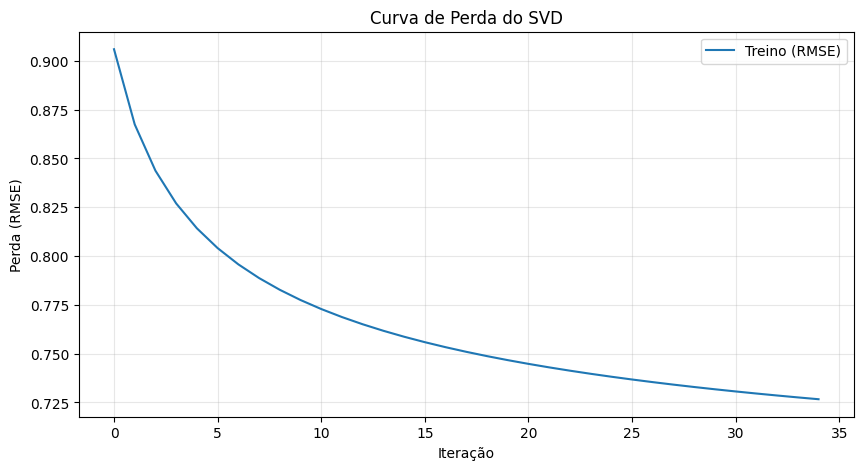

In [83]:
# Visualizar a curva de perda
plt.figure(figsize=(10, 5))
plt.plot(losses_svd, label='Treino (RMSE)')
plt.xlabel('Iteração')
plt.ylabel('Perda (RMSE)')
plt.title('Curva de Perda do SVD')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [69]:
# Gerar previsões usando o modelo SVD
predictions_svd = Q @ Sigma @ P.T

print("\nComparação de previsões no conjunto de treinamento:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(train_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = train_matrix[user, movie]
    pred = predictions_svd[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")

# Selecionar 10 pontos aleatórios com avaliações = 0
zero_indices = np.where(train_matrix == 0)
random_indices = np.random.choice(len(zero_indices[0]), 10, replace=False)
print("\nPontos com avaliações = 0:")
for i in random_indices:
    user = zero_indices[0][i]
    movie = zero_indices[1][i]
    pred = predictions_svd[user, movie]
    print(f"Usuário {user}, Filme {movie}: Previsto = {pred:.2f}")


Comparação de previsões no conjunto de treinamento:

Pontos com avaliações > 0:
Usuário 466, Filme 474: Real = 4.00, Previsto = 4.21, Erro = 0.21
Usuário 43, Filme 755: Real = 3.00, Previsto = 2.89, Erro = 0.11
Usuário 499, Filme 583: Real = 1.00, Previsto = 2.98, Erro = 1.98
Usuário 221, Filme 475: Real = 3.00, Previsto = 2.88, Erro = 0.12
Usuário 372, Filme 280: Real = 3.00, Previsto = 3.78, Erro = 0.78
Usuário 253, Filme 120: Real = 3.00, Previsto = 4.28, Erro = 1.28
Usuário 9, Filme 156: Real = 5.00, Previsto = 4.03, Erro = 0.97
Usuário 173, Filme 455: Real = 1.00, Previsto = 1.00, Erro = 0.00
Usuário 607, Filme 15: Real = 2.00, Previsto = 2.05, Erro = 0.05
Usuário 298, Filme 18: Real = 1.00, Previsto = 3.46, Erro = 2.46

Pontos com avaliações = 0:
Usuário 319, Filme 638: Previsto = 3.96
Usuário 656, Filme 687: Previsto = 4.56
Usuário 184, Filme 649: Previsto = 4.49
Usuário 798, Filme 921: Previsto = 4.48
Usuário 867, Filme 872: Previsto = 1.42
Usuário 811, Filme 1093: Previsto = 

In [70]:
# Comparar previsões com valores reais no conjunto de validação
print("\nComparação de previsões SVD no conjunto de validação:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(val_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = val_matrix[user, movie]
    pred = predictions_svd[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")


Comparação de previsões SVD no conjunto de validação:

Pontos com avaliações > 0:
Usuário 754, Filme 288: Real = 1.00, Previsto = 2.99, Erro = 1.99
Usuário 807, Filme 332: Real = 4.00, Previsto = 4.18, Erro = 0.18
Usuário 755, Filme 431: Real = 4.00, Previsto = 3.81, Erro = 0.19
Usuário 810, Filme 288: Real = 2.00, Previsto = 4.29, Erro = 2.29
Usuário 122, Filme 846: Real = 4.00, Previsto = 3.61, Erro = 0.39
Usuário 637, Filme 185: Real = 5.00, Previsto = 4.28, Erro = 0.72
Usuário 130, Filme 220: Real = 3.00, Previsto = 4.35, Erro = 1.35
Usuário 639, Filme 539: Real = 3.00, Previsto = 3.56, Erro = 0.56
Usuário 21, Filme 501: Real = 4.00, Previsto = 5.30, Erro = 1.30
Usuário 536, Filme 60: Real = 4.00, Previsto = 3.12, Erro = 0.88


In [71]:
# Comparar previsões com valores reais no conjunto de teste
print("\nComparação de previsões no conjunto de teste:")

# Selecionar 10 pontos aleatórios com avaliações > 0
nonzero_indices = np.where(test_matrix > 0)
random_indices = np.random.choice(len(nonzero_indices[0]), 10, replace=False)
print("\nPontos com avaliações > 0:")
for i in random_indices:
    user = nonzero_indices[0][i]
    movie = nonzero_indices[1][i]
    real = test_matrix[user, movie]
    pred = predictions_svd[user, movie]
    print(f"Usuário {user}, Filme {movie}: Real = {real:.2f}, Previsto = {pred:.2f}, Erro = {abs(real-pred):.2f}")



Comparação de previsões no conjunto de teste:

Pontos com avaliações > 0:
Usuário 243, Filme 553: Real = 3.00, Previsto = 2.88, Erro = 0.12
Usuário 405, Filme 431: Real = 5.00, Previsto = 3.68, Erro = 1.32
Usuário 507, Filme 213: Real = 3.00, Previsto = 3.82, Erro = 0.82
Usuário 280, Filme 681: Real = 3.00, Previsto = 3.93, Erro = 0.93
Usuário 154, Filme 291: Real = 3.00, Previsto = 2.76, Erro = 0.24
Usuário 224, Filme 135: Real = 5.00, Previsto = 4.52, Erro = 0.48
Usuário 478, Filme 70: Real = 1.00, Previsto = 3.61, Erro = 2.61
Usuário 723, Filme 905: Real = 1.00, Previsto = 2.35, Erro = 1.35
Usuário 876, Filme 401: Real = 3.00, Previsto = 3.71, Erro = 0.71
Usuário 672, Filme 339: Real = 5.00, Previsto = 3.98, Erro = 1.02


In [72]:
# Calcular RMSE no conjunto de validação
val_mask = (val_matrix > 0).astype(int)
val_error = val_mask * (val_matrix - predictions_svd)
val_rmse = np.sqrt(np.sum(val_error**2) / np.sum(val_mask))
print(f"\nRMSE no conjunto de validação: {val_rmse:.4f}")



RMSE no conjunto de validação: 0.9869


 ## 5. Funções de Avaliação

In [ ]:
def calculate_rmse(true_matrix, pred_matrix):
    """
    Calcula o RMSE apenas nas posições onde há avaliações conhecidas
    """
    mask = (true_matrix > 0).astype(int)
    error = mask * (true_matrix - pred_matrix)
    rmse = np.sqrt(np.sum(error**2) / np.sum(mask))
    return rmse

def calculate_recall_at_k(true_matrix, pred_matrix, exclude_matrix=None, k=10, threshold=4):
    """
    Calcula o Recall para cada usuário e retorna a média
    Considera apenas filmes com rating >= threshold como relevantes
    exclude_matrix: matriz adicional para excluir (ex: validação quando calculando teste)
    """
    n_users, n_movies = true_matrix.shape
    recalls = []

    for user in range(n_users):
        # Filtra ratings e usuários
        relevant_movies = np.where(true_matrix[user] >= threshold)[0]
        if len(relevant_movies) == 0:
            continue

        # Encontra top-k filmes recomendados (maiores predições)
        pred_user = pred_matrix[user].copy()
        train_movies = np.where(train_matrix[user] > 0)[0] # Excluir filmes já vistos no treino
        pred_user[train_movies] = -np.inf
        if exclude_matrix is not None:
            exclude_movies = np.where(exclude_matrix[user] > 0)[0] # Excluir filmes da matriz adicional
            pred_user[exclude_movies] = -np.inf

        top_k_movies = np.argsort(pred_user)[-k:][::-1]

        # Calcular recall
        relevant_in_top_k = len(np.intersect1d(relevant_movies, top_k_movies))
        recall = relevant_in_top_k / len(relevant_movies)
        recalls.append(recall)

    return np.mean(recalls) if recalls else 0.0


### 5.1 Avaliação e Seleção de Hiperparâmetros

No futuro, o ideal seria programar em classe com herança.

In [93]:
def evaluate_nmf_hyperparams(train_matrix, val_matrix):
    """
    Avalia diferentes hiperparâmetros para NMF usando conjunto de validação
    """
    k_values = [5, 10, 15, 20]
    alpha_values = [0.0001, 0.001, 0.01]
    beta_values = [0.0001, 0.001, 0.01]

    best_rmse = float('inf')
    best_recall = 0.0
    best_params_rmse = {}
    best_params_recall = {}
    results = []

    print("Avaliando hiperparâmetros do NMF...")

    for k in k_values:
        for alpha in alpha_values:
            for beta in beta_values:
                print(f"Testando k={k}, alpha={alpha}, beta={beta}")

                # Treina
                W, H, losses = nmf(train_matrix, k, max_iter=200, alpha=alpha, beta=beta)
                predictions = W @ H

                # Avalia no conjunto de validação
                rmse = calculate_rmse(val_matrix, predictions)
                recall = calculate_recall_at_k(val_matrix, predictions)

                results.append({
                    'k': k, 'alpha': alpha, 'beta': beta,
                    'rmse': rmse, 'recall': recall
                })

                # Atualiza os melhores parâmetros para RMSE
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params_rmse = {'k': k, 'alpha': alpha, 'beta': beta}

                # Atualiza os melhores parâmetros para Recall
                if recall > best_recall:
                    best_recall = recall
                    best_params_recall = {'k': k, 'alpha': alpha, 'beta': beta}

                print(f"RMSE: {rmse:.4f}, Recall: {recall:.4f}")

    print(f"\nMelhores parâmetros NMF (RMSE): {best_params_rmse} (RMSE: {best_rmse:.4f})")
    print(f"Melhores parâmetros NMF (Recall): {best_params_recall} (Recall: {best_recall:.4f})")
    return best_params_rmse, best_params_recall, results

def evaluate_svd_hyperparams(train_matrix, val_matrix):
    """
    Avalia diferentes hiperparâmetros para SVD usando conjunto de validação
    """
    k_values = [5, 15]
    reg_values = [0, 0.001, 0.1]

    best_rmse = float('inf')
    best_recall = 0.0
    best_params_rmse = {}
    best_params_recall = {}
    results = []

    print("Avaliando hiperparâmetros do SVD...")

    for k in k_values:
        for reg in reg_values:
            print(f"Testando k={k}, regularization={reg}")

            # Treina
            Q, Sigma, P, losses = svd(train_matrix, k, max_iter=20, regularization=reg)
            predictions = Q @ Sigma @ P.T

            # Avalia no conjunto de validação
            rmse = calculate_rmse(val_matrix, predictions)
            recall = calculate_recall_at_k(val_matrix, predictions)

            results.append({
                'k': k, 'regularization': reg,
                'rmse': rmse, 'recall': recall
            })

            # Atualiza os melhores parâmetros para RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_params_rmse = {'k': k, 'regularization': reg}

            # Atualizar os melhores parâmetros para Recall
            if recall > best_recall:
                best_recall = recall
                best_params_recall = {'k': k, 'regularization': reg}

            print(f"RMSE: {rmse:.4f}, Recall: {recall:.4f}")

    print(f"\nMelhores parâmetros SVD (RMSE): {best_params_rmse} (RMSE: {best_rmse:.4f})")
    print(f"Melhores parâmetros SVD (Recall): {best_params_recall} (Recall: {best_recall:.4f})")
    return best_params_rmse, best_params_recall, results

def evaluate_slim_hyperparams(train_matrix, val_matrix):
    """
    Avalia diferentes hiperparâmetros para SLIM usando conjunto de validação
    """
    learning_rate = 0.000001
    l2_values = [0.001, 0.01, 0.1]
    l1_values = [0.001, 0.01, 0.1]

    best_rmse = float('inf')
    best_recall = 0.0
    best_params_rmse = {}
    best_params_recall = {}
    results = []

    print("Avaliando hiperparâmetros do SLIM...")

    for l2_reg in l2_values:
        for l1_reg in l1_values:
            print(f"Testando l2_reg={l2_reg}, l1_reg={l1_reg}")

            # Treina
            W, losses = slim(train_matrix, learning_rate, l2_reg, l1_reg, max_iter=50)
            predictions = train_matrix @ W

            # Avalia no conjunto de validação
            rmse = calculate_rmse(val_matrix, predictions)
            recall = calculate_recall_at_k(val_matrix, predictions)

            results.append({
                'l2_reg': l2_reg, 'l1_reg': l1_reg,
                'rmse': rmse, 'recall': recall
            })

            # Atualiza os melhores parâmetros para RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_params_rmse = {'l2_reg': l2_reg, 'l1_reg': l1_reg}

            # Atualiza os melhores parâmetros para Recall
            if recall > best_recall:
                best_recall = recall
                best_params_recall = {'l2_reg': l2_reg, 'l1_reg': l1_reg}

            print(f"RMSE: {rmse:.4f}, Recall: {recall:.4f}")

    print(f"\nMelhores parâmetros SLIM (RMSE): {best_params_rmse} (RMSE: {best_rmse:.4f})")
    print(f"Melhores parâmetros SLIM (Recall): {best_params_recall} (Recall: {best_recall:.4f})")
    return best_params_rmse, best_params_recall, results

In [89]:

np.random.seed(42)  # Para reprodutibilidade

# NMF
print("=== Avaliando NMF ===")
best_nmf_params_rmse, best_nmf_params_recall, nmf_results = evaluate_nmf_hyperparams(train_matrix, val_matrix)

=== Avaliando NMF ===
Avaliando hiperparâmetros do NMF...
Testando k=5, alpha=0.0001, beta=0.0001
Convergência alcançada após 54 iterações
RMSE: 3.0387, Recall: 0.2313
Testando k=5, alpha=0.0001, beta=0.001
Convergência alcançada após 71 iterações
RMSE: 3.1171, Recall: 0.2271
Testando k=5, alpha=0.0001, beta=0.01
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é muito grande, normalizando. Considere diminuir o valor de beta.
H é m

In [98]:
# SVD
print("\n=== Avaliando SVD ===")
best_svd_params_rmse, best_svd_params_recall, svd_results = evaluate_svd_hyperparams(train_matrix, val_matrix)


=== Avaliando SVD ===
Avaliando hiperparâmetros do SVD...
Testando k=5, regularization=0


Número máximo de iterações (20) alcançado sem convergência
RMSE: 0.9602, Recall: 0.0836
Testando k=5, regularization=0.001
Número máximo de iterações (20) alcançado sem convergência
RMSE: 0.9602, Recall: 0.0836
Testando k=5, regularization=0.1
Número máximo de iterações (20) alcançado sem convergência
RMSE: 0.9600, Recall: 0.0834
Testando k=15, regularization=0
Número máximo de iterações (20) alcançado sem convergência
RMSE: 0.9990, Recall: 0.0771
Testando k=15, regularization=0.001
Número máximo de iterações (20) alcançado sem convergência
RMSE: 0.9990, Recall: 0.0771
Testando k=15, regularization=0.1
Número máximo de iterações (20) alcançado sem convergência
RMSE: 0.9983, Recall: 0.0780

Melhores parâmetros SVD (RMSE): {'k': 5, 'regularization': 0.1} (RMSE: 0.9600)
Melhores parâmetros SVD (Recall): {'k': 5, 'regularization': 0} (Recall: 0.0836)


In [97]:
# SLIM
print("\n=== Avaliando SLIM ===")
best_slim_params_rmse, best_slim_params_recall, slim_results = evaluate_slim_hyperparams(train_matrix, val_matrix)


=== Avaliando SLIM ===
Avaliando hiperparâmetros do SLIM...
Testando l2_reg=0.001, l1_reg=0.001
Número máximo de iterações (50) alcançado sem convergência
RMSE: 2.5574, Recall: 0.2384
Testando l2_reg=0.001, l1_reg=0.01
Número máximo de iterações (50) alcançado sem convergência
RMSE: 2.5563, Recall: 0.2403
Testando l2_reg=0.001, l1_reg=0.1
Número máximo de iterações (50) alcançado sem convergência
RMSE: 2.5568, Recall: 0.2404
Testando l2_reg=0.01, l1_reg=0.001
Número máximo de iterações (50) alcançado sem convergência
RMSE: 2.5563, Recall: 0.2456
Testando l2_reg=0.01, l1_reg=0.01
Número máximo de iterações (50) alcançado sem convergência
RMSE: 2.5543, Recall: 0.2411
Testando l2_reg=0.01, l1_reg=0.1
Número máximo de iterações (50) alcançado sem convergência
RMSE: 2.5559, Recall: 0.2420
Testando l2_reg=0.1, l1_reg=0.001
Número máximo de iterações (50) alcançado sem convergência
RMSE: 2.5549, Recall: 0.2426
Testando l2_reg=0.1, l1_reg=0.01
Número máximo de iterações (50) alcançado sem con

### 5.2 Modelos Finais com os Melhores Hiperparâmetros

In [ ]:
# Treinar NMF final
print("Treinando NMF otimizado para RMSE...")
W_final_rmse, H_final_rmse, losses_nmf_final_rmse = nmf(
    train_matrix,
    best_nmf_params_rmse['k'],
    max_iter=500,
    alpha=best_nmf_params_rmse['alpha'],
    beta=best_nmf_params_rmse['beta']
)
predictions_nmf_final_rmse = W_final_rmse @ H_final_rmse

print("Treinando NMF otimizado para Recall...")
W_final_recall, H_final_recall, losses_nmf_final_recall = nmf(
    train_matrix,
    best_nmf_params_recall['k'],
    max_iter=500,
    alpha=best_nmf_params_recall['alpha'],
    beta=best_nmf_params_recall['beta']
)
predictions_nmf_final_recall = W_final_recall @ H_final_recall

# Treina SVD final
print("Treinando SVD otimizado para RMSE...")
Q_final_rmse, Sigma_final_rmse, P_final_rmse, losses_svd_final_rmse = svd(
    train_matrix,
    best_svd_params_rmse['k'],
    max_iter=200,
    regularization=best_svd_params_rmse['regularization']
)
predictions_svd_final_rmse = Q_final_rmse @ Sigma_final_rmse @ P_final_rmse.T

print("Treinando SVD otimizado para Recall...")
Q_final_recall, Sigma_final_recall, P_final_recall, losses_svd_final_recall = svd(
    train_matrix,
    best_svd_params_recall['k'],
    max_iter=200,
    regularization=best_svd_params_recall['regularization']
)
predictions_svd_final_recall = Q_final_recall @ Sigma_final_recall @ P_final_recall.T

# Treinar SLIM final
print("Treinando SLIM otimizado para RMSE...")
W_slim_final_rmse, losses_slim_final_rmse = slim(
    train_matrix,
    learning_rate=0.000001,
    l2_reg=best_slim_params_rmse['l2_reg'],
    l1_reg=best_slim_params_rmse['l1_reg'],
    max_iter=100
)
predictions_slim_final_rmse = train_matrix @ W_slim_final_rmse

print("Treinando SLIM otimizado para Recall...")
W_slim_final_recall, losses_slim_final_recall = slim(
    train_matrix,
    learning_rate=0.000001,
    l2_reg=best_slim_params_recall['l2_reg'],
    l1_reg=best_slim_params_recall['l1_reg'],
    max_iter=100
)
predictions_slim_final_recall = train_matrix @ W_slim_final_recall

Treinando NMF otimizado para RMSE...
Convergência alcançada após 53 iterações
Treinando NMF otimizado para Recall...
Convergência alcançada após 60 iterações
Treinando SVD otimizado para RMSE...
Convergência alcançada após 33 iterações
Treinando SVD otimizado para Recall@10...
Convergência alcançada após 34 iterações
Treinando SLIM otimizado para RMSE...
Convergência alcançada após 68 iterações
Treinando SLIM otimizado para Recall@10...
Convergência alcançada após 70 iterações


### 5.3 Avaliação Final no Conjunto de Teste

In [ ]:
# Modelos otimizados para RMSE
rmse_nmf_test_rmse = calculate_rmse(test_matrix, predictions_nmf_final_rmse)
rmse_svd_test_rmse = calculate_rmse(test_matrix, predictions_svd_final_rmse)
rmse_slim_test_rmse = calculate_rmse(test_matrix, predictions_slim_final_rmse)

recall_nmf_test_rmse = calculate_recall_at_k(test_matrix, predictions_nmf_final_rmse, exclude_matrix=val_matrix)
recall_svd_test_rmse = calculate_recall_at_k(test_matrix, predictions_svd_final_rmse, exclude_matrix=val_matrix)
recall_slim_test_rmse = calculate_recall_at_k(test_matrix, predictions_slim_final_rmse, exclude_matrix=val_matrix)

# Modelos otimizados para Recall
rmse_nmf_test_recall = calculate_rmse(test_matrix, predictions_nmf_final_recall)
rmse_svd_test_recall = calculate_rmse(test_matrix, predictions_svd_final_recall)
rmse_slim_test_recall = calculate_rmse(test_matrix, predictions_slim_final_recall)

recall_nmf_test_recall = calculate_recall_at_k(test_matrix, predictions_nmf_final_recall, exclude_matrix=val_matrix)
recall_svd_test_recall = calculate_recall_at_k(test_matrix, predictions_svd_final_recall, exclude_matrix=val_matrix)
recall_slim_test_recall = calculate_recall_at_k(test_matrix, predictions_slim_final_recall, exclude_matrix=val_matrix)

print(f"\nResultados dos modelos otimizados para RMSE:")
print(f"NMF  - RMSE: {rmse_nmf_test_rmse:.4f}, Recall: {recall_nmf_test_rmse:.4f}")
print(f"SVD  - RMSE: {rmse_svd_test_rmse:.4f}, Recall: {recall_svd_test_rmse:.4f}")
print(f"SLIM - RMSE: {rmse_slim_test_rmse:.4f}, Recall: {recall_slim_test_rmse:.4f}")

print(f"\nResultados dos modelos otimizados para Recall:")
print(f"NMF  - RMSE: {rmse_nmf_test_recall:.4f}, Recall: {recall_nmf_test_recall:.4f}")
print(f"SVD  - RMSE: {rmse_svd_test_recall:.4f}, Recall: {recall_svd_test_recall:.4f}")
print(f"SLIM - RMSE: {rmse_slim_test_recall:.4f}, Recall: {recall_slim_test_recall:.4f}")


Resultados dos modelos otimizados para RMSE:
NMF  - RMSE: 2.8606, Recall@10: 0.3180
SVD  - RMSE: 0.9385, Recall@10: 0.0703
SLIM - RMSE: 2.4937, Recall@10: 0.2754

Resultados dos modelos otimizados para Recall@10:
NMF  - RMSE: 2.8551, Recall@10: 0.3255
SVD  - RMSE: 0.9387, Recall@10: 0.0691
SLIM - RMSE: 2.4873, Recall@10: 0.2742


### Visualização dos Resultados

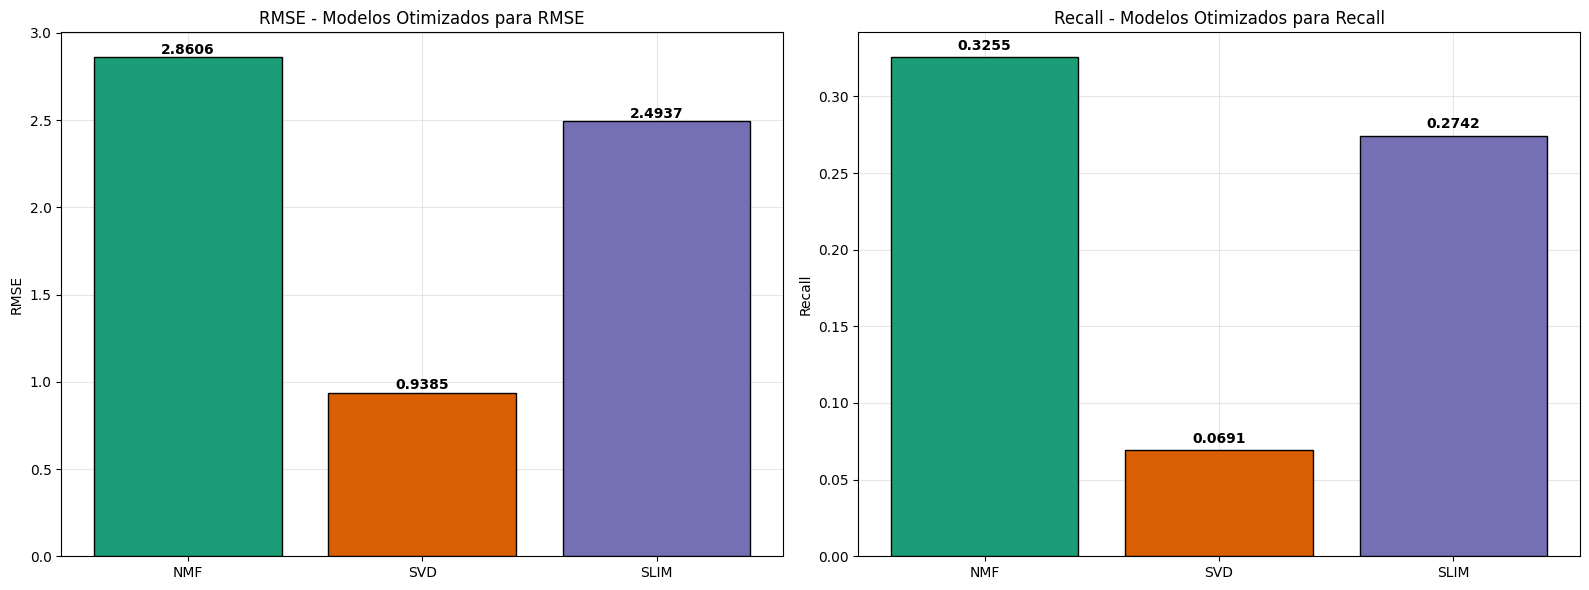

In [112]:
models = ['NMF', 'SVD', 'SLIM']
rmse_values_rmse = [rmse_nmf_test_rmse, rmse_svd_test_rmse, rmse_slim_test_rmse]
recall_values_recall = [recall_nmf_test_recall, recall_svd_test_recall, recall_slim_test_recall]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.Dark2.colors

# RMSE dos modelos otimizados para RMSE
bars1 = ax1.bar(models, rmse_values_rmse, color=colors, edgecolor='black', zorder = 4)
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE - Modelos Otimizados para RMSE')
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars1, rmse_values_rmse):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Recall dos modelos otimizados para Recall
bars2 = ax2.bar(models, recall_values_recall, color=colors, edgecolor='black', zorder = 4)
ax2.set_ylabel('Recall')
ax2.set_title('Recall - Modelos Otimizados para Recall')
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars2, recall_values_recall):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Comentário

Podemos ver que o modelo com melhor RMSE (SVD) foi o que teve o pior recall. Mostrando que o RMSE, sozinho, não deve ser usado para inferir totalmente a qualidade do modelo. O modelo com melhor recall foi o NMF, que teve o pior RMSE.